In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          DataCollatorWithPadding,
                          Trainer, TrainingArguments)
# from torch.utils.data import Dataset, DataLoader
from datasets import Dataset
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from src.utils.custom_trainer import CustomTrainer

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Фиксируем random seed

In [2]:
# фиксируем рандомный сид
seed  = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

In [3]:
# детектируем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Задание констант

In [4]:
classes_list = ["Algebra", "Geometry and Trigonometry", "Calculus and Analysis",
                "Probability and Statistics", "Number Theory", "Combinatorics and Discrete Math",
                "Linear Algebra", "Abstract Algebra and Topology"]
n_classes = len(classes_list)

train_csv_file = './data/train.csv'

batch_size = 8
num_epoches = 3

class_weights=torch.tensor([0.4903152069297401, 
                            0.5230364476386037, 
                            1.2290410132689988, 
                            3.4655612244897958, 
                            0.7324766355140186, 
                            0.6964285714285714, 
                            13.40625, 
                            14.151041666666666])

model_name = 'google-bert/bert-base-uncased'

# Извлечение данных

In [13]:
df = pd.read_csv(train_csv_file)
df = df.rename(columns={'Question': 'text'})

train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Исследование данных

Classes conts on train: [2078. 1948.  829.  294. 1391. 1463.   76.   72.]
Class diff counts: [   0.  130. 1249. 1784.  687.  615. 2002. 2006.]
Class weights: [0.4903152069297401, 0.5230364476386037, 1.2290410132689988, 3.4655612244897958, 0.7324766355140186, 0.6964285714285714, 13.40625, 14.151041666666666]


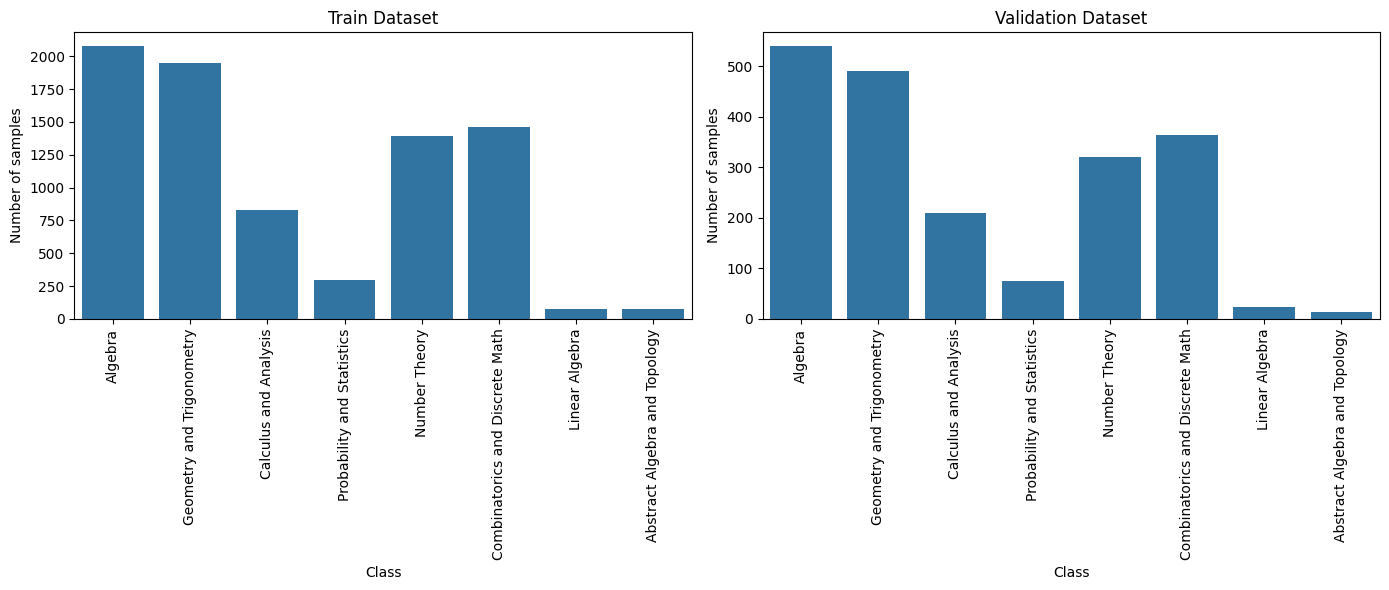

In [14]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(n_classes)
for idx, row in train_df.iterrows():
    label = row['label']
    train_class_counts[label] += 1
    
print(f"Classes conts on train: {train_class_counts}")
print(f"Class diff counts: {np.max(train_class_counts) - train_class_counts}")

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(n_classes)
for idx, row in val_df.iterrows():
    label = row['label']
    val_class_counts[label] += 1

# посчитаем веса для каждого класса
class_weights = (sum(train_class_counts.tolist()) / (n_classes * train_class_counts)).tolist()
print(f"Class weights: {class_weights}")
class_weights = torch.tensor(class_weights)

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=classes_list, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of samples')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=classes_list, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of samples')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Add generated data

In [7]:
generated_df = pd.read_csv('./data/generated/generated_train.csv')
generated_df = generated_df.rename(columns={'Question': 'text'})

result_df = pd.concat([train_df, generated_df], ignore_index=True)

Classes conts on train: [2078. 1948.  829.  294. 1391. 1463.   94.   72.]
Class weights: [0.49139797882579406, 0.524191478439425, 1.2317551266586249, 3.4732142857142856, 0.7340941768511862, 0.6979665071770335, 10.863031914893616, 14.182291666666666]


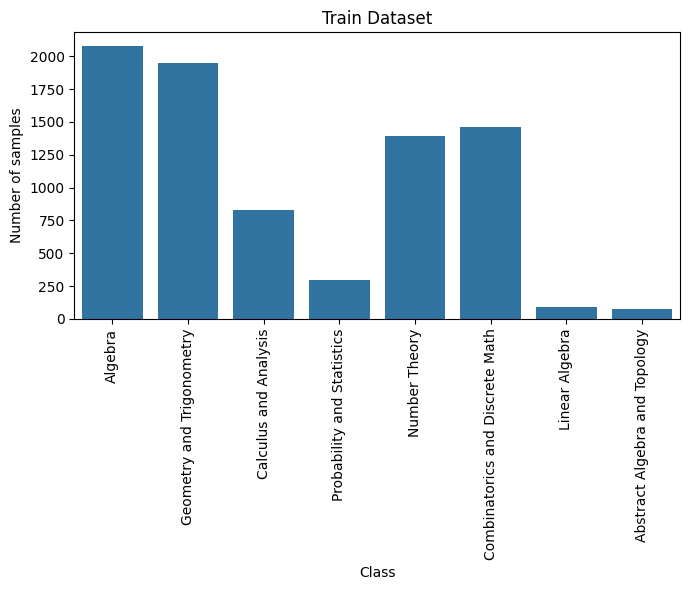

In [12]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(n_classes)
for idx, row in result_df.iterrows():
    label = row['label']
    train_class_counts[label] += 1
    
print(f"Classes conts on train: {train_class_counts}")

# посчитаем веса для каждого класса
new_class_weights = (sum(train_class_counts.tolist()) / (n_classes * train_class_counts)).tolist()
print(f"Class weights: {new_class_weights}")

# Создать barplot
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Barplot для обучающего набора данных
sns.barplot(x=classes_list, y=train_class_counts)
ax.set_title('Train Dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Number of samples')
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Импортируем модель

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer) #? нужен для чего

model.to(device)

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Формируем datasets и dataloaders

Для обучения с помощью Trainer API нам ну нужно вручную создавать dataset, dataloader и т д. Все за нас может сделать hugging face API, нам надо только
создать подходящие по формату датасеты. Но оставим пока этот код здесь, в будущем попробуем написать ручной пайплайн обучения.

In [8]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [9]:
# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

In [10]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 2038/2038 [00:00<00:00, 11693.59 examples/s]


# Baseline модель

In [11]:
def evaleate_model(model, trainer, tokenized_val_dataset, device):
    model.to(device)
    model.eval()
    predictions = trainer.predict(tokenized_val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    true_lables = tokenized_val_dataset['label']
    cm = confusion_matrix(true_lables, preds)
    report = classification_report(true_lables, preds)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    # micro_f1 = f1_score(true_lables, preds, average='mocro')
    return (
        cm, 
        report, 
        accuracy, 
        # micro_f1,
    )

In [12]:
def plot_confusion_matrix(cm, classes, model_name=None, save_file_path=None):
    """
    Plots a confusion matrix for visualizing classification performance.

    This function takes the confusion matrix and class labels to create a heatmap
    visualization. It also allows saving the plot to a file or returning it
    without saving.

    Args:
        cm (numpy.ndarray): The confusion matrix array.
        classes (list): List of class names used in the model.
        model_name (string, optional): Name of the model for naming purposes. If None,
                                        does not set a title. Defaults to None.
        save_file_path (str, optional): Path where the plot should be saved. If None,
                                         the plot is displayed but not saved. Defaults to None.

    Returns:
        str: The filename or None if no saving occurs.

    Raises:
        AssertionError: If model_name is provided but save_file_path is not set.
    """
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        if model_name:
            assert save_file_path is not None
            plt.title(f"Confusion Matrix for {model_name}")
        else:
            plt.title("Confusion Matrix")
        
        if save_file_path is None:
            plt.show()
        else:
            # Verify that model_name exists before saving
            assert model_name, "model_name must be provided when save_file_path is not None"
            plt.savefig(f"{save_file_path}/confusion_matrix_{model_name}.jpg")
            return f"{save_file_path}/confusion_matrix_{model_name}.jpg"

100%|██████████| 255/255 [00:14<00:00, 17.08it/s]

Metrics for current model:
Test accuracy: 0.0270
              precision    recall  f1-score   support

           0       0.88      0.06      0.10       540
           1       0.00      0.00      0.00       491
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00        74
           4       0.38      0.01      0.02       321
           5       0.00      0.00      0.00       364
           6       0.01      0.92      0.02        24
           7       0.00      0.00      0.00        14

    accuracy                           0.03      2038
   macro avg       0.16      0.12      0.02      2038
weighted avg       0.29      0.03      0.03      2038




/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

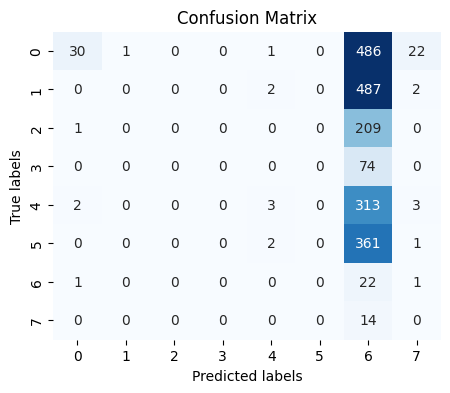

In [13]:
baseline_trainer = Trainer(
    model=model,
    eval_dataset=tokenized_val_dataset,
)

# cm, _, accuracy, micro_f1 = evaleate_model(model, tokenized_val_dataset, device)
cm, validation_report, accuracy = evaleate_model(model, baseline_trainer, tokenized_val_dataset, device)
print("Metrics for current model:")
print(f'Test accuracy: {accuracy:.4f}')
print(validation_report)
# print(f'Test F1 micro: {micro_f1:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))

# Тренировка модели

In [14]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    validation_accuracy = accuracy_score(predictions, labels)
    validation_precision = precision_score(predictions, labels)
    validation_recall = recall_score(predictions, labels)
    # validation_f1_micro = f1_score(predictions, labels, average='micro')
    # validation_f1_macro = f1_score(predictions, labels, average='macro')

    return {
        'accuracy': validation_accuracy,
        'precision': validation_precision,
        'recall': validation_recall,
        # 'f1_micro': validation_f1_micro,
        # 'f1_macro': validation_f1_macro
    }

In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epoches,
    weight_decay=0.01,
    logging_dir='./logs',  
    save_steps=1000, # сохранение чекпоинтов модели каждые 1000 шагов# директория для логов TensorBoard
    logging_steps=10
)

In [16]:

#! bug: there are some troubles with using compute_metrics function: 
#! Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    # compute_metrics=compute_metrics,
    class_weights=class_weights.to(device)
)

In [17]:
trainer.train()

  0%|          | 10/3057 [00:02<10:14,  4.96it/s]

{'loss': 2.0851, 'grad_norm': 10.497392654418945, 'learning_rate': 4.983644095518482e-05, 'epoch': 0.01}


                                                 
  0%|          | 11/3057 [00:17<4:03:57,  4.81s/it]

{'eval_loss': 2.016972064971924, 'eval_runtime': 15.0285, 'eval_samples_per_second': 135.609, 'eval_steps_per_second': 16.968, 'epoch': 0.01}


  1%|          | 20/3057 [00:19<19:37,  2.58it/s]  

{'loss': 2.0214, 'grad_norm': 9.746626853942871, 'learning_rate': 4.9672881910369644e-05, 'epoch': 0.02}


                                                 
  1%|          | 21/3057 [00:34<4:06:13,  4.87s/it]

{'eval_loss': 1.9631630182266235, 'eval_runtime': 15.0884, 'eval_samples_per_second': 135.071, 'eval_steps_per_second': 16.9, 'epoch': 0.02}


  1%|          | 30/3057 [00:36<19:47,  2.55it/s]  

{'loss': 1.929, 'grad_norm': 6.925655364990234, 'learning_rate': 4.950932286555447e-05, 'epoch': 0.03}


                                                 
  1%|          | 31/3057 [00:51<4:06:26,  4.89s/it]

{'eval_loss': 1.9223908185958862, 'eval_runtime': 15.1546, 'eval_samples_per_second': 134.481, 'eval_steps_per_second': 16.827, 'epoch': 0.03}


  1%|▏         | 40/3057 [00:53<19:48,  2.54it/s]  

{'loss': 1.6896, 'grad_norm': 7.346555709838867, 'learning_rate': 4.9345763820739286e-05, 'epoch': 0.04}


                                                 
  1%|▏         | 41/3057 [01:08<4:06:08,  4.90s/it]

{'eval_loss': 1.753740668296814, 'eval_runtime': 15.1846, 'eval_samples_per_second': 134.215, 'eval_steps_per_second': 16.793, 'epoch': 0.04}


  2%|▏         | 50/3057 [01:10<19:46,  2.53it/s]  

{'loss': 1.5324, 'grad_norm': 9.423462867736816, 'learning_rate': 4.9182204775924114e-05, 'epoch': 0.05}


                                                 
  2%|▏         | 51/3057 [01:26<4:05:29,  4.90s/it]

{'eval_loss': 1.655864953994751, 'eval_runtime': 15.1952, 'eval_samples_per_second': 134.121, 'eval_steps_per_second': 16.782, 'epoch': 0.05}


  2%|▏         | 60/3057 [01:28<19:26,  2.57it/s]  

{'loss': 1.4184, 'grad_norm': 8.566905975341797, 'learning_rate': 4.901864573110893e-05, 'epoch': 0.06}


                                                 
  2%|▏         | 61/3057 [01:43<4:04:57,  4.91s/it]

{'eval_loss': 1.6915949583053589, 'eval_runtime': 15.2253, 'eval_samples_per_second': 133.856, 'eval_steps_per_second': 16.748, 'epoch': 0.06}


  2%|▏         | 70/3057 [01:45<19:36,  2.54it/s]  

{'loss': 1.8943, 'grad_norm': 14.441062927246094, 'learning_rate': 4.8855086686293755e-05, 'epoch': 0.07}


                                                 
  2%|▏         | 71/3057 [02:00<4:04:20,  4.91s/it]

{'eval_loss': 1.4463262557983398, 'eval_runtime': 15.2292, 'eval_samples_per_second': 133.822, 'eval_steps_per_second': 16.744, 'epoch': 0.07}


  3%|▎         | 80/3057 [02:02<19:37,  2.53it/s]  

{'loss': 1.3453, 'grad_norm': 8.293103218078613, 'learning_rate': 4.8691527641478576e-05, 'epoch': 0.08}


                                                 
  3%|▎         | 81/3057 [02:17<4:03:34,  4.91s/it]

{'eval_loss': 1.4255998134613037, 'eval_runtime': 15.2262, 'eval_samples_per_second': 133.848, 'eval_steps_per_second': 16.747, 'epoch': 0.08}


  3%|▎         | 90/3057 [02:19<19:34,  2.53it/s]  

{'loss': 1.0372, 'grad_norm': 10.549301147460938, 'learning_rate': 4.85279685966634e-05, 'epoch': 0.09}


                                                 
  3%|▎         | 91/3057 [02:35<4:02:55,  4.91s/it]

{'eval_loss': 1.4514414072036743, 'eval_runtime': 15.2402, 'eval_samples_per_second': 133.725, 'eval_steps_per_second': 16.732, 'epoch': 0.09}


  3%|▎         | 100/3057 [02:37<19:29,  2.53it/s] 

{'loss': 1.3686, 'grad_norm': 5.950197696685791, 'learning_rate': 4.8364409551848225e-05, 'epoch': 0.1}


                                                  
  3%|▎         | 101/3057 [02:52<4:01:59,  4.91s/it]

{'eval_loss': 1.3503705263137817, 'eval_runtime': 15.2336, 'eval_samples_per_second': 133.784, 'eval_steps_per_second': 16.739, 'epoch': 0.1}


  4%|▎         | 110/3057 [02:54<19:25,  2.53it/s]  

{'loss': 1.4363, 'grad_norm': 9.66813850402832, 'learning_rate': 4.820085050703304e-05, 'epoch': 0.11}


                                                  
  4%|▎         | 111/3057 [03:09<4:01:20,  4.92s/it]

{'eval_loss': 1.301594614982605, 'eval_runtime': 15.243, 'eval_samples_per_second': 133.701, 'eval_steps_per_second': 16.729, 'epoch': 0.11}


  4%|▍         | 120/3057 [03:11<19:04,  2.57it/s]  

{'loss': 1.4261, 'grad_norm': 6.530904293060303, 'learning_rate': 4.803729146221787e-05, 'epoch': 0.12}


                                                  
  4%|▍         | 121/3057 [03:27<4:00:38,  4.92s/it]

{'eval_loss': 1.2290716171264648, 'eval_runtime': 15.264, 'eval_samples_per_second': 133.517, 'eval_steps_per_second': 16.706, 'epoch': 0.12}


  4%|▍         | 130/3057 [03:29<19:20,  2.52it/s]  

{'loss': 1.2105, 'grad_norm': 5.996703147888184, 'learning_rate': 4.787373241740268e-05, 'epoch': 0.13}


                                                  
  4%|▍         | 131/3057 [03:44<3:59:52,  4.92s/it]

{'eval_loss': 1.1745280027389526, 'eval_runtime': 15.252, 'eval_samples_per_second': 133.622, 'eval_steps_per_second': 16.719, 'epoch': 0.13}


  5%|▍         | 140/3057 [03:46<18:54,  2.57it/s]  

{'loss': 1.3658, 'grad_norm': 15.406180381774902, 'learning_rate': 4.771017337258751e-05, 'epoch': 0.14}


                                                  
  5%|▍         | 141/3057 [04:01<3:58:30,  4.91s/it]

{'eval_loss': 1.167313575744629, 'eval_runtime': 15.2343, 'eval_samples_per_second': 133.777, 'eval_steps_per_second': 16.739, 'epoch': 0.14}


  5%|▍         | 150/3057 [04:03<19:09,  2.53it/s]  

{'loss': 1.2956, 'grad_norm': 9.753364562988281, 'learning_rate': 4.754661432777233e-05, 'epoch': 0.15}


                                                  
  5%|▍         | 151/3057 [04:19<3:57:34,  4.91s/it]

{'eval_loss': 1.1457781791687012, 'eval_runtime': 15.2107, 'eval_samples_per_second': 133.984, 'eval_steps_per_second': 16.764, 'epoch': 0.15}


  5%|▌         | 160/3057 [04:20<19:05,  2.53it/s]  

{'loss': 0.8979, 'grad_norm': 15.752606391906738, 'learning_rate': 4.738305528295715e-05, 'epoch': 0.16}


                                                  
  5%|▌         | 161/3057 [04:36<3:56:53,  4.91s/it]

{'eval_loss': 1.1510143280029297, 'eval_runtime': 15.2198, 'eval_samples_per_second': 133.905, 'eval_steps_per_second': 16.754, 'epoch': 0.16}


  6%|▌         | 170/3057 [04:38<19:02,  2.53it/s]  

{'loss': 0.8383, 'grad_norm': 8.483813285827637, 'learning_rate': 4.721949623814197e-05, 'epoch': 0.17}


                                                  
  6%|▌         | 171/3057 [04:53<3:55:51,  4.90s/it]

{'eval_loss': 1.0932037830352783, 'eval_runtime': 15.2031, 'eval_samples_per_second': 134.052, 'eval_steps_per_second': 16.773, 'epoch': 0.17}


  6%|▌         | 180/3057 [04:55<18:55,  2.53it/s]  

{'loss': 1.3208, 'grad_norm': 6.344223976135254, 'learning_rate': 4.705593719332679e-05, 'epoch': 0.18}


                                                  
  6%|▌         | 181/3057 [05:10<3:55:04,  4.90s/it]

{'eval_loss': 1.1950747966766357, 'eval_runtime': 15.2099, 'eval_samples_per_second': 133.992, 'eval_steps_per_second': 16.765, 'epoch': 0.18}


  6%|▌         | 190/3057 [05:12<18:45,  2.55it/s]  

{'loss': 1.1875, 'grad_norm': 9.394011497497559, 'learning_rate': 4.689237814851162e-05, 'epoch': 0.19}


                                                  
  6%|▌         | 191/3057 [05:28<3:54:11,  4.90s/it]

{'eval_loss': 1.0492398738861084, 'eval_runtime': 15.208, 'eval_samples_per_second': 134.008, 'eval_steps_per_second': 16.767, 'epoch': 0.19}


  7%|▋         | 200/3057 [05:30<18:48,  2.53it/s]  

{'loss': 1.0, 'grad_norm': 10.081082344055176, 'learning_rate': 4.6728819103696434e-05, 'epoch': 0.2}


                                                  
  7%|▋         | 201/3057 [05:45<3:53:24,  4.90s/it]

{'eval_loss': 1.1982609033584595, 'eval_runtime': 15.2052, 'eval_samples_per_second': 134.033, 'eval_steps_per_second': 16.771, 'epoch': 0.2}


  7%|▋         | 210/3057 [05:47<18:44,  2.53it/s]  

{'loss': 1.7851, 'grad_norm': 23.109956741333008, 'learning_rate': 4.656526005888126e-05, 'epoch': 0.21}


                                                  
  7%|▋         | 211/3057 [06:02<3:52:38,  4.90s/it]

{'eval_loss': 1.1759010553359985, 'eval_runtime': 15.2108, 'eval_samples_per_second': 133.984, 'eval_steps_per_second': 16.764, 'epoch': 0.21}


  7%|▋         | 220/3057 [06:04<18:38,  2.54it/s]  

{'loss': 1.1487, 'grad_norm': 7.161492347717285, 'learning_rate': 4.6401701014066076e-05, 'epoch': 0.22}


                                                  
  7%|▋         | 221/3057 [06:19<3:51:37,  4.90s/it]

{'eval_loss': 1.1626245975494385, 'eval_runtime': 15.1977, 'eval_samples_per_second': 134.099, 'eval_steps_per_second': 16.779, 'epoch': 0.22}


  8%|▊         | 230/3057 [06:21<18:29,  2.55it/s]  

{'loss': 1.3534, 'grad_norm': 9.927486419677734, 'learning_rate': 4.6238141969250903e-05, 'epoch': 0.23}


                                                  
  8%|▊         | 231/3057 [06:37<3:50:53,  4.90s/it]

{'eval_loss': 1.071355938911438, 'eval_runtime': 15.2075, 'eval_samples_per_second': 134.013, 'eval_steps_per_second': 16.768, 'epoch': 0.23}


  8%|▊         | 240/3057 [06:39<18:31,  2.53it/s]  

{'loss': 1.164, 'grad_norm': 17.49813461303711, 'learning_rate': 4.6074582924435724e-05, 'epoch': 0.24}


                                                  
  8%|▊         | 241/3057 [06:54<3:50:03,  4.90s/it]

{'eval_loss': 1.212387204170227, 'eval_runtime': 15.202, 'eval_samples_per_second': 134.061, 'eval_steps_per_second': 16.774, 'epoch': 0.24}


  8%|▊         | 250/3057 [06:56<18:20,  2.55it/s]  

{'loss': 1.0259, 'grad_norm': 5.0734148025512695, 'learning_rate': 4.5911023879620545e-05, 'epoch': 0.25}


                                                  
  8%|▊         | 251/3057 [07:11<3:49:03,  4.90s/it]

{'eval_loss': 1.11418879032135, 'eval_runtime': 15.1948, 'eval_samples_per_second': 134.125, 'eval_steps_per_second': 16.782, 'epoch': 0.25}


  9%|▊         | 260/3057 [07:13<18:26,  2.53it/s]  

{'loss': 1.0457, 'grad_norm': 7.468320369720459, 'learning_rate': 4.5747464834805366e-05, 'epoch': 0.26}


                                                  
  9%|▊         | 261/3057 [07:28<3:48:23,  4.90s/it]

{'eval_loss': 0.9895594716072083, 'eval_runtime': 15.1973, 'eval_samples_per_second': 134.103, 'eval_steps_per_second': 16.779, 'epoch': 0.26}


  9%|▉         | 270/3057 [07:30<18:10,  2.56it/s]  

{'loss': 1.3133, 'grad_norm': 25.619279861450195, 'learning_rate': 4.558390578999019e-05, 'epoch': 0.26}


                                                  
  9%|▉         | 271/3057 [07:46<3:47:28,  4.90s/it]

{'eval_loss': 1.1061546802520752, 'eval_runtime': 15.2016, 'eval_samples_per_second': 134.065, 'eval_steps_per_second': 16.775, 'epoch': 0.26}


  9%|▉         | 280/3057 [07:48<18:16,  2.53it/s]  

{'loss': 0.9285, 'grad_norm': 26.31336212158203, 'learning_rate': 4.5420346745175015e-05, 'epoch': 0.27}


                                                  
  9%|▉         | 281/3057 [08:03<3:46:39,  4.90s/it]

{'eval_loss': 1.2518985271453857, 'eval_runtime': 15.1927, 'eval_samples_per_second': 134.144, 'eval_steps_per_second': 16.784, 'epoch': 0.27}


  9%|▉         | 290/3057 [08:05<17:52,  2.58it/s]  

{'loss': 1.0557, 'grad_norm': 9.39880657196045, 'learning_rate': 4.525678770035983e-05, 'epoch': 0.28}


                                                  
 10%|▉         | 291/3057 [08:20<3:45:59,  4.90s/it]

{'eval_loss': 0.9460753202438354, 'eval_runtime': 15.2189, 'eval_samples_per_second': 133.913, 'eval_steps_per_second': 16.756, 'epoch': 0.28}


 10%|▉         | 300/3057 [08:22<18:08,  2.53it/s]  

{'loss': 0.9985, 'grad_norm': 8.722805976867676, 'learning_rate': 4.5093228655544657e-05, 'epoch': 0.29}


                                                  
 10%|▉         | 301/3057 [08:37<3:44:47,  4.89s/it]

{'eval_loss': 1.0670344829559326, 'eval_runtime': 15.1763, 'eval_samples_per_second': 134.288, 'eval_steps_per_second': 16.802, 'epoch': 0.29}


 10%|█         | 310/3057 [08:39<17:48,  2.57it/s]  

{'loss': 0.8324, 'grad_norm': 10.499107360839844, 'learning_rate': 4.492966961072948e-05, 'epoch': 0.3}


                                                  
 10%|█         | 311/3057 [08:55<3:43:00,  4.87s/it]

{'eval_loss': 1.0041215419769287, 'eval_runtime': 15.119, 'eval_samples_per_second': 134.797, 'eval_steps_per_second': 16.866, 'epoch': 0.3}


 10%|█         | 320/3057 [08:56<18:00,  2.53it/s]  

{'loss': 1.1048, 'grad_norm': 11.959856986999512, 'learning_rate': 4.47661105659143e-05, 'epoch': 0.31}


                                                  
 11%|█         | 321/3057 [09:12<3:43:13,  4.90s/it]

{'eval_loss': 1.006118893623352, 'eval_runtime': 15.183, 'eval_samples_per_second': 134.229, 'eval_steps_per_second': 16.795, 'epoch': 0.31}


 11%|█         | 330/3057 [09:14<17:50,  2.55it/s]  

{'loss': 1.193, 'grad_norm': 15.62662124633789, 'learning_rate': 4.460255152109912e-05, 'epoch': 0.32}


                                                  
 11%|█         | 331/3057 [09:29<3:42:50,  4.90s/it]

{'eval_loss': 1.208412766456604, 'eval_runtime': 15.2145, 'eval_samples_per_second': 133.951, 'eval_steps_per_second': 16.76, 'epoch': 0.32}


 11%|█         | 340/3057 [09:31<17:53,  2.53it/s]  

{'loss': 1.2854, 'grad_norm': 45.59336471557617, 'learning_rate': 4.443899247628394e-05, 'epoch': 0.33}


                                                  
 11%|█         | 341/3057 [09:46<3:41:17,  4.89s/it]

{'eval_loss': 1.0758702754974365, 'eval_runtime': 15.1572, 'eval_samples_per_second': 134.458, 'eval_steps_per_second': 16.824, 'epoch': 0.33}


 11%|█▏        | 350/3057 [09:48<17:47,  2.54it/s]  

{'loss': 0.7899, 'grad_norm': 8.287923812866211, 'learning_rate': 4.427543343146876e-05, 'epoch': 0.34}


                                                  
 11%|█▏        | 351/3057 [10:03<3:39:08,  4.86s/it]

{'eval_loss': 0.9551221132278442, 'eval_runtime': 15.0594, 'eval_samples_per_second': 135.33, 'eval_steps_per_second': 16.933, 'epoch': 0.34}


 12%|█▏        | 360/3057 [10:05<17:38,  2.55it/s]  

{'loss': 1.0657, 'grad_norm': 17.142822265625, 'learning_rate': 4.411187438665358e-05, 'epoch': 0.35}


                                                  
 12%|█▏        | 361/3057 [10:21<3:40:12,  4.90s/it]

{'eval_loss': 0.9278499484062195, 'eval_runtime': 15.2033, 'eval_samples_per_second': 134.05, 'eval_steps_per_second': 16.773, 'epoch': 0.35}


 12%|█▏        | 370/3057 [10:23<17:41,  2.53it/s]  

{'loss': 0.9551, 'grad_norm': 5.766735553741455, 'learning_rate': 4.39483153418384e-05, 'epoch': 0.36}


                                                  
 12%|█▏        | 371/3057 [10:38<3:39:58,  4.91s/it]

{'eval_loss': 0.9500328898429871, 'eval_runtime': 15.2403, 'eval_samples_per_second': 133.725, 'eval_steps_per_second': 16.732, 'epoch': 0.36}


 12%|█▏        | 380/3057 [10:40<17:36,  2.53it/s]  

{'loss': 0.8004, 'grad_norm': 8.487220764160156, 'learning_rate': 4.378475629702323e-05, 'epoch': 0.37}


                                                  
 12%|█▏        | 381/3057 [10:55<3:39:11,  4.91s/it]

{'eval_loss': 0.8972674012184143, 'eval_runtime': 15.243, 'eval_samples_per_second': 133.701, 'eval_steps_per_second': 16.729, 'epoch': 0.37}


 13%|█▎        | 390/3057 [10:57<17:32,  2.53it/s]  

{'loss': 0.9958, 'grad_norm': 9.085944175720215, 'learning_rate': 4.362119725220805e-05, 'epoch': 0.38}


                                                  
 13%|█▎        | 391/3057 [11:13<3:38:12,  4.91s/it]

{'eval_loss': 0.9640598297119141, 'eval_runtime': 15.2348, 'eval_samples_per_second': 133.773, 'eval_steps_per_second': 16.738, 'epoch': 0.38}


 13%|█▎        | 400/3057 [11:14<17:29,  2.53it/s]  

{'loss': 1.0173, 'grad_norm': 12.214139938354492, 'learning_rate': 4.345763820739287e-05, 'epoch': 0.39}


                                                  
 13%|█▎        | 401/3057 [11:30<3:36:29,  4.89s/it]

{'eval_loss': 0.9713756442070007, 'eval_runtime': 15.1665, 'eval_samples_per_second': 134.375, 'eval_steps_per_second': 16.813, 'epoch': 0.39}


 13%|█▎        | 410/3057 [11:32<17:17,  2.55it/s]  

{'loss': 0.9258, 'grad_norm': 18.055994033813477, 'learning_rate': 4.329407916257769e-05, 'epoch': 0.4}


                                                  
 13%|█▎        | 411/3057 [11:47<3:35:52,  4.90s/it]

{'eval_loss': 0.9179577231407166, 'eval_runtime': 15.181, 'eval_samples_per_second': 134.246, 'eval_steps_per_second': 16.797, 'epoch': 0.4}


 14%|█▎        | 420/3057 [11:49<17:12,  2.55it/s]  

{'loss': 1.2265, 'grad_norm': 27.3856201171875, 'learning_rate': 4.3130520117762514e-05, 'epoch': 0.41}


                                                  
 14%|█▍        | 421/3057 [12:04<3:35:50,  4.91s/it]

{'eval_loss': 0.9453449845314026, 'eval_runtime': 15.2439, 'eval_samples_per_second': 133.693, 'eval_steps_per_second': 16.728, 'epoch': 0.41}


 14%|█▍        | 430/3057 [12:06<17:01,  2.57it/s]  

{'loss': 0.648, 'grad_norm': 7.58497953414917, 'learning_rate': 4.2966961072947335e-05, 'epoch': 0.42}


                                                  
 14%|█▍        | 431/3057 [12:22<3:34:45,  4.91s/it]

{'eval_loss': 0.9917661547660828, 'eval_runtime': 15.2311, 'eval_samples_per_second': 133.805, 'eval_steps_per_second': 16.742, 'epoch': 0.42}


 14%|█▍        | 440/3057 [12:23<17:15,  2.53it/s]  

{'loss': 0.9376, 'grad_norm': 10.502372741699219, 'learning_rate': 4.2803402028132156e-05, 'epoch': 0.43}


                                                  
 14%|█▍        | 441/3057 [12:39<3:34:42,  4.92s/it]

{'eval_loss': 0.9309239387512207, 'eval_runtime': 15.2733, 'eval_samples_per_second': 133.436, 'eval_steps_per_second': 16.696, 'epoch': 0.43}


 15%|█▍        | 450/3057 [12:41<16:56,  2.57it/s]  

{'loss': 0.8742, 'grad_norm': 8.311375617980957, 'learning_rate': 4.263984298331698e-05, 'epoch': 0.44}


                                                  
 15%|█▍        | 451/3057 [12:56<3:33:20,  4.91s/it]

{'eval_loss': 0.8902962803840637, 'eval_runtime': 15.2438, 'eval_samples_per_second': 133.694, 'eval_steps_per_second': 16.728, 'epoch': 0.44}


 15%|█▌        | 460/3057 [12:58<17:01,  2.54it/s]  

{'loss': 1.1703, 'grad_norm': 23.07338523864746, 'learning_rate': 4.24762839385018e-05, 'epoch': 0.45}


                                                  
 15%|█▌        | 461/3057 [13:13<3:31:36,  4.89s/it]

{'eval_loss': 0.8614238500595093, 'eval_runtime': 15.1678, 'eval_samples_per_second': 134.363, 'eval_steps_per_second': 16.812, 'epoch': 0.45}


 15%|█▌        | 470/3057 [13:15<16:54,  2.55it/s]  

{'loss': 1.0144, 'grad_norm': 37.03746032714844, 'learning_rate': 4.2312724893686625e-05, 'epoch': 0.46}


                                                  
 15%|█▌        | 471/3057 [13:30<3:28:45,  4.84s/it]

{'eval_loss': 0.8413321375846863, 'eval_runtime': 15.0146, 'eval_samples_per_second': 135.734, 'eval_steps_per_second': 16.983, 'epoch': 0.46}


 16%|█▌        | 480/3057 [13:32<16:42,  2.57it/s]  

{'loss': 1.0018, 'grad_norm': 11.155856132507324, 'learning_rate': 4.2149165848871446e-05, 'epoch': 0.47}


                                                  
 16%|█▌        | 481/3057 [13:47<3:27:34,  4.83s/it]

{'eval_loss': 0.8945373892784119, 'eval_runtime': 14.9897, 'eval_samples_per_second': 135.96, 'eval_steps_per_second': 17.012, 'epoch': 0.47}


 16%|█▌        | 490/3057 [13:49<16:20,  2.62it/s]  

{'loss': 0.5392, 'grad_norm': 5.783177852630615, 'learning_rate': 4.198560680405627e-05, 'epoch': 0.48}


                                                  
 16%|█▌        | 491/3057 [14:05<3:28:54,  4.88s/it]

{'eval_loss': 0.8956910371780396, 'eval_runtime': 15.1742, 'eval_samples_per_second': 134.307, 'eval_steps_per_second': 16.805, 'epoch': 0.48}


 16%|█▋        | 500/3057 [14:06<16:38,  2.56it/s]  

{'loss': 1.2118, 'grad_norm': 9.423903465270996, 'learning_rate': 4.182204775924109e-05, 'epoch': 0.49}


                                                  
 16%|█▋        | 501/3057 [14:22<3:29:08,  4.91s/it]

{'eval_loss': 0.8719831705093384, 'eval_runtime': 15.2359, 'eval_samples_per_second': 133.763, 'eval_steps_per_second': 16.737, 'epoch': 0.49}


 17%|█▋        | 510/3057 [14:24<16:47,  2.53it/s]  

{'loss': 0.6253, 'grad_norm': 20.77742576599121, 'learning_rate': 4.165848871442591e-05, 'epoch': 0.5}


                                                  
 17%|█▋        | 511/3057 [14:39<3:28:52,  4.92s/it]

{'eval_loss': 0.8648099303245544, 'eval_runtime': 15.2668, 'eval_samples_per_second': 133.492, 'eval_steps_per_second': 16.703, 'epoch': 0.5}


 17%|█▋        | 520/3057 [14:41<16:20,  2.59it/s]  

{'loss': 0.9111, 'grad_norm': 8.82291316986084, 'learning_rate': 4.149492966961073e-05, 'epoch': 0.51}


                                                  
 17%|█▋        | 521/3057 [14:56<3:27:54,  4.92s/it]

{'eval_loss': 0.9553768038749695, 'eval_runtime': 15.2762, 'eval_samples_per_second': 133.41, 'eval_steps_per_second': 16.693, 'epoch': 0.51}


 17%|█▋        | 530/3057 [14:58<16:38,  2.53it/s]  

{'loss': 1.0386, 'grad_norm': 6.934678077697754, 'learning_rate': 4.133137062479555e-05, 'epoch': 0.52}


                                                  
 17%|█▋        | 531/3057 [15:14<3:26:44,  4.91s/it]

{'eval_loss': 0.9380028247833252, 'eval_runtime': 15.2287, 'eval_samples_per_second': 133.827, 'eval_steps_per_second': 16.745, 'epoch': 0.52}


 18%|█▊        | 540/3057 [15:16<16:22,  2.56it/s]  

{'loss': 0.6117, 'grad_norm': 6.999282360076904, 'learning_rate': 4.116781157998038e-05, 'epoch': 0.53}


                                                  
 18%|█▊        | 541/3057 [15:31<3:25:52,  4.91s/it]

{'eval_loss': 0.9243910312652588, 'eval_runtime': 15.2369, 'eval_samples_per_second': 133.755, 'eval_steps_per_second': 16.736, 'epoch': 0.53}


 18%|█▊        | 550/3057 [15:33<16:33,  2.52it/s]  

{'loss': 0.8456, 'grad_norm': 37.2715950012207, 'learning_rate': 4.100425253516519e-05, 'epoch': 0.54}


                                                  
 18%|█▊        | 551/3057 [15:48<3:25:36,  4.92s/it]

{'eval_loss': 0.9296011328697205, 'eval_runtime': 15.2674, 'eval_samples_per_second': 133.487, 'eval_steps_per_second': 16.702, 'epoch': 0.54}


 18%|█▊        | 560/3057 [15:50<16:21,  2.55it/s]  

{'loss': 1.7364, 'grad_norm': 14.516989707946777, 'learning_rate': 4.084069349035002e-05, 'epoch': 0.55}


                                                  
 18%|█▊        | 561/3057 [16:06<3:24:44,  4.92s/it]

{'eval_loss': 0.9127388000488281, 'eval_runtime': 15.2697, 'eval_samples_per_second': 133.467, 'eval_steps_per_second': 16.7, 'epoch': 0.55}


 19%|█▊        | 570/3057 [16:08<16:24,  2.53it/s]  

{'loss': 0.8937, 'grad_norm': 13.322196006774902, 'learning_rate': 4.067713444553484e-05, 'epoch': 0.56}


                                                  
 19%|█▊        | 571/3057 [16:23<3:23:54,  4.92s/it]

{'eval_loss': 0.8854820132255554, 'eval_runtime': 15.2629, 'eval_samples_per_second': 133.526, 'eval_steps_per_second': 16.707, 'epoch': 0.56}


 19%|█▉        | 580/3057 [16:25<16:22,  2.52it/s]  

{'loss': 1.1375, 'grad_norm': 9.909713745117188, 'learning_rate': 4.051357540071966e-05, 'epoch': 0.57}


                                                  
 19%|█▉        | 581/3057 [16:40<3:23:03,  4.92s/it]

{'eval_loss': 0.839715301990509, 'eval_runtime': 15.2599, 'eval_samples_per_second': 133.553, 'eval_steps_per_second': 16.711, 'epoch': 0.57}


 19%|█▉        | 590/3057 [16:42<16:16,  2.53it/s]  

{'loss': 0.6166, 'grad_norm': 15.614977836608887, 'learning_rate': 4.035001635590448e-05, 'epoch': 0.58}


                                                  
 19%|█▉        | 591/3057 [16:58<3:22:25,  4.93s/it]

{'eval_loss': 0.8601416945457458, 'eval_runtime': 15.2738, 'eval_samples_per_second': 133.431, 'eval_steps_per_second': 16.695, 'epoch': 0.58}


 20%|█▉        | 600/3057 [17:00<16:14,  2.52it/s]  

{'loss': 0.9109, 'grad_norm': 12.8038911819458, 'learning_rate': 4.0186457311089304e-05, 'epoch': 0.59}


                                                  
 20%|█▉        | 601/3057 [17:15<3:19:54,  4.88s/it]

{'eval_loss': 0.8740777969360352, 'eval_runtime': 15.139, 'eval_samples_per_second': 134.619, 'eval_steps_per_second': 16.844, 'epoch': 0.59}


 20%|█▉        | 610/3057 [17:17<16:09,  2.52it/s]  

{'loss': 0.8093, 'grad_norm': 6.607056617736816, 'learning_rate': 4.0022898266274125e-05, 'epoch': 0.6}


                                                  
 20%|█▉        | 611/3057 [17:32<3:19:53,  4.90s/it]

{'eval_loss': 0.9621428847312927, 'eval_runtime': 15.2011, 'eval_samples_per_second': 134.07, 'eval_steps_per_second': 16.775, 'epoch': 0.6}


 20%|██        | 620/3057 [17:34<16:01,  2.54it/s]  

{'loss': 0.3452, 'grad_norm': 10.576019287109375, 'learning_rate': 3.9859339221458946e-05, 'epoch': 0.61}


                                                  
 20%|██        | 621/3057 [17:49<3:19:55,  4.92s/it]

{'eval_loss': 0.8833191394805908, 'eval_runtime': 15.2756, 'eval_samples_per_second': 133.415, 'eval_steps_per_second': 16.693, 'epoch': 0.61}


 21%|██        | 630/3057 [17:51<16:01,  2.52it/s]  

{'loss': 0.7101, 'grad_norm': 2.8248913288116455, 'learning_rate': 3.9695780176643773e-05, 'epoch': 0.62}


                                                  
 21%|██        | 631/3057 [18:07<3:18:57,  4.92s/it]

{'eval_loss': 0.8807907700538635, 'eval_runtime': 15.2579, 'eval_samples_per_second': 133.57, 'eval_steps_per_second': 16.713, 'epoch': 0.62}


 21%|██        | 640/3057 [18:09<15:56,  2.53it/s]  

{'loss': 1.1422, 'grad_norm': 59.128997802734375, 'learning_rate': 3.953222113182859e-05, 'epoch': 0.63}


                                                  
 21%|██        | 641/3057 [18:24<3:18:06,  4.92s/it]

{'eval_loss': 0.8750286102294922, 'eval_runtime': 15.2599, 'eval_samples_per_second': 133.553, 'eval_steps_per_second': 16.71, 'epoch': 0.63}


 21%|██▏       | 650/3057 [18:26<15:51,  2.53it/s]  

{'loss': 0.8859, 'grad_norm': 12.240593910217285, 'learning_rate': 3.9368662087013415e-05, 'epoch': 0.64}


                                                  
 21%|██▏       | 651/3057 [18:41<3:17:18,  4.92s/it]

{'eval_loss': 0.9009068608283997, 'eval_runtime': 15.2612, 'eval_samples_per_second': 133.542, 'eval_steps_per_second': 16.709, 'epoch': 0.64}


 22%|██▏       | 660/3057 [18:43<15:48,  2.53it/s]  

{'loss': 0.6618, 'grad_norm': 2.5064480304718018, 'learning_rate': 3.9205103042198236e-05, 'epoch': 0.65}


                                                  
 22%|██▏       | 661/3057 [18:59<3:16:39,  4.92s/it]

{'eval_loss': 0.8012011647224426, 'eval_runtime': 15.2745, 'eval_samples_per_second': 133.425, 'eval_steps_per_second': 16.694, 'epoch': 0.65}


 22%|██▏       | 670/3057 [19:01<15:32,  2.56it/s]  

{'loss': 0.6663, 'grad_norm': 9.263131141662598, 'learning_rate': 3.904154399738306e-05, 'epoch': 0.66}


                                                  
 22%|██▏       | 671/3057 [19:16<3:15:43,  4.92s/it]

{'eval_loss': 0.8590506911277771, 'eval_runtime': 15.276, 'eval_samples_per_second': 133.411, 'eval_steps_per_second': 16.693, 'epoch': 0.66}


 22%|██▏       | 680/3057 [19:18<15:39,  2.53it/s]  

{'loss': 0.8995, 'grad_norm': 7.510094165802002, 'learning_rate': 3.887798495256788e-05, 'epoch': 0.67}


                                                  
 22%|██▏       | 681/3057 [19:33<3:15:00,  4.92s/it]

{'eval_loss': 0.8896939754486084, 'eval_runtime': 15.2746, 'eval_samples_per_second': 133.424, 'eval_steps_per_second': 16.694, 'epoch': 0.67}


 23%|██▎       | 690/3057 [19:35<15:38,  2.52it/s]  

{'loss': 1.2263, 'grad_norm': 5.288886547088623, 'learning_rate': 3.87144259077527e-05, 'epoch': 0.68}


                                                  
 23%|██▎       | 691/3057 [19:51<3:14:16,  4.93s/it]

{'eval_loss': 0.8671830892562866, 'eval_runtime': 15.2798, 'eval_samples_per_second': 133.379, 'eval_steps_per_second': 16.689, 'epoch': 0.68}


 23%|██▎       | 700/3057 [19:53<15:28,  2.54it/s]  

{'loss': 0.6967, 'grad_norm': 21.905893325805664, 'learning_rate': 3.8550866862937526e-05, 'epoch': 0.69}


                                                  
 23%|██▎       | 701/3057 [20:08<3:12:19,  4.90s/it]

{'eval_loss': 0.8048030734062195, 'eval_runtime': 15.19, 'eval_samples_per_second': 134.167, 'eval_steps_per_second': 16.787, 'epoch': 0.69}


 23%|██▎       | 710/3057 [20:10<15:25,  2.54it/s]  

{'loss': 0.8839, 'grad_norm': 18.292661666870117, 'learning_rate': 3.838730781812234e-05, 'epoch': 0.7}


                                                  
 23%|██▎       | 711/3057 [20:25<3:12:40,  4.93s/it]

{'eval_loss': 0.7905133366584778, 'eval_runtime': 15.2876, 'eval_samples_per_second': 133.311, 'eval_steps_per_second': 16.68, 'epoch': 0.7}


 24%|██▎       | 720/3057 [20:27<15:17,  2.55it/s]  

{'loss': 0.5624, 'grad_norm': 8.39360237121582, 'learning_rate': 3.822374877330717e-05, 'epoch': 0.71}


                                                  
 24%|██▎       | 721/3057 [20:43<3:11:53,  4.93s/it]

{'eval_loss': 0.7763134837150574, 'eval_runtime': 15.2954, 'eval_samples_per_second': 133.242, 'eval_steps_per_second': 16.672, 'epoch': 0.71}


 24%|██▍       | 730/3057 [20:45<15:23,  2.52it/s]  

{'loss': 0.8252, 'grad_norm': 16.14741325378418, 'learning_rate': 3.806018972849198e-05, 'epoch': 0.72}


                                                  
 24%|██▍       | 731/3057 [21:00<3:10:58,  4.93s/it]

{'eval_loss': 0.9168531894683838, 'eval_runtime': 15.278, 'eval_samples_per_second': 133.394, 'eval_steps_per_second': 16.691, 'epoch': 0.72}


 24%|██▍       | 740/3057 [21:02<15:19,  2.52it/s]  

{'loss': 0.8647, 'grad_norm': 1.9936435222625732, 'learning_rate': 3.789663068367681e-05, 'epoch': 0.73}


                                                  
 24%|██▍       | 741/3057 [21:17<3:10:06,  4.92s/it]

{'eval_loss': 0.8722192645072937, 'eval_runtime': 15.273, 'eval_samples_per_second': 133.438, 'eval_steps_per_second': 16.696, 'epoch': 0.73}


 25%|██▍       | 750/3057 [21:19<15:15,  2.52it/s]  

{'loss': 0.9588, 'grad_norm': 21.160337448120117, 'learning_rate': 3.773307163886163e-05, 'epoch': 0.74}


                                                  
 25%|██▍       | 751/3057 [21:35<3:08:22,  4.90s/it]

{'eval_loss': 0.8328537344932556, 'eval_runtime': 15.1979, 'eval_samples_per_second': 134.098, 'eval_steps_per_second': 16.779, 'epoch': 0.74}


 25%|██▍       | 760/3057 [21:36<15:06,  2.53it/s]  

{'loss': 0.8642, 'grad_norm': 9.032712936401367, 'learning_rate': 3.756951259404645e-05, 'epoch': 0.75}


                                                  
 25%|██▍       | 761/3057 [21:52<3:05:46,  4.85s/it]

{'eval_loss': 0.7304720878601074, 'eval_runtime': 15.0459, 'eval_samples_per_second': 135.452, 'eval_steps_per_second': 16.948, 'epoch': 0.75}


 25%|██▌       | 770/3057 [21:53<14:40,  2.60it/s]  

{'loss': 0.6085, 'grad_norm': 6.098639011383057, 'learning_rate': 3.740595354923128e-05, 'epoch': 0.76}


                                                  
 25%|██▌       | 771/3057 [22:09<3:04:55,  4.85s/it]

{'eval_loss': 0.725073516368866, 'eval_runtime': 15.0683, 'eval_samples_per_second': 135.251, 'eval_steps_per_second': 16.923, 'epoch': 0.76}


 26%|██▌       | 780/3057 [22:11<14:45,  2.57it/s]  

{'loss': 0.4544, 'grad_norm': 18.03314208984375, 'learning_rate': 3.7242394504416094e-05, 'epoch': 0.77}


                                                  
 26%|██▌       | 781/3057 [22:26<3:06:00,  4.90s/it]

{'eval_loss': 0.7645466327667236, 'eval_runtime': 15.2169, 'eval_samples_per_second': 133.93, 'eval_steps_per_second': 16.758, 'epoch': 0.77}


 26%|██▌       | 790/3057 [22:28<14:56,  2.53it/s]  

{'loss': 0.8251, 'grad_norm': 11.62907886505127, 'learning_rate': 3.707883545960092e-05, 'epoch': 0.78}


                                                  
 26%|██▌       | 791/3057 [22:43<3:05:36,  4.91s/it]

{'eval_loss': 0.8255524039268494, 'eval_runtime': 15.2409, 'eval_samples_per_second': 133.719, 'eval_steps_per_second': 16.731, 'epoch': 0.78}


 26%|██▌       | 800/3057 [22:45<14:51,  2.53it/s]  

{'loss': 0.9656, 'grad_norm': 12.742919921875, 'learning_rate': 3.6915276414785736e-05, 'epoch': 0.79}


                                                  
 26%|██▌       | 801/3057 [23:01<3:05:03,  4.92s/it]

{'eval_loss': 0.8381789922714233, 'eval_runtime': 15.2662, 'eval_samples_per_second': 133.498, 'eval_steps_per_second': 16.704, 'epoch': 0.79}


 26%|██▋       | 810/3057 [23:02<14:48,  2.53it/s]  

{'loss': 0.8201, 'grad_norm': 3.3230719566345215, 'learning_rate': 3.675171736997056e-05, 'epoch': 0.79}


                                                  
 27%|██▋       | 811/3057 [23:18<3:04:23,  4.93s/it]

{'eval_loss': 0.8047479391098022, 'eval_runtime': 15.2783, 'eval_samples_per_second': 133.392, 'eval_steps_per_second': 16.69, 'epoch': 0.79}


 27%|██▋       | 820/3057 [23:20<14:47,  2.52it/s]  

{'loss': 0.695, 'grad_norm': 22.572290420532227, 'learning_rate': 3.658815832515538e-05, 'epoch': 0.8}


                                                  
 27%|██▋       | 821/3057 [23:35<3:02:45,  4.90s/it]

{'eval_loss': 0.8824542164802551, 'eval_runtime': 15.2054, 'eval_samples_per_second': 134.031, 'eval_steps_per_second': 16.77, 'epoch': 0.8}


 27%|██▋       | 830/3057 [23:37<14:26,  2.57it/s]  

{'loss': 1.3302, 'grad_norm': 9.084345817565918, 'learning_rate': 3.6424599280340205e-05, 'epoch': 0.81}


                                                  
 27%|██▋       | 831/3057 [23:52<3:02:04,  4.91s/it]

{'eval_loss': 0.7694408297538757, 'eval_runtime': 15.234, 'eval_samples_per_second': 133.78, 'eval_steps_per_second': 16.739, 'epoch': 0.81}


 27%|██▋       | 840/3057 [23:54<14:36,  2.53it/s]  

{'loss': 1.0066, 'grad_norm': 33.77360534667969, 'learning_rate': 3.6261040235525026e-05, 'epoch': 0.82}


                                                  
 28%|██▊       | 841/3057 [24:10<2:59:44,  4.87s/it]

{'eval_loss': 0.7536665201187134, 'eval_runtime': 15.0878, 'eval_samples_per_second': 135.076, 'eval_steps_per_second': 16.901, 'epoch': 0.82}


 28%|██▊       | 850/3057 [24:11<14:21,  2.56it/s]  

{'loss': 1.3321, 'grad_norm': 15.648296356201172, 'learning_rate': 3.609748119070985e-05, 'epoch': 0.83}


                                                  
 28%|██▊       | 851/3057 [24:27<2:58:09,  4.85s/it]

{'eval_loss': 0.8115331530570984, 'eval_runtime': 15.0293, 'eval_samples_per_second': 135.602, 'eval_steps_per_second': 16.967, 'epoch': 0.83}


 28%|██▊       | 860/3057 [24:29<14:18,  2.56it/s]  

{'loss': 0.8783, 'grad_norm': 14.009063720703125, 'learning_rate': 3.5933922145894674e-05, 'epoch': 0.84}


                                                  
 28%|██▊       | 861/3057 [24:44<2:58:52,  4.89s/it]

{'eval_loss': 0.7303809523582458, 'eval_runtime': 15.1635, 'eval_samples_per_second': 134.402, 'eval_steps_per_second': 16.817, 'epoch': 0.84}


 28%|██▊       | 870/3057 [24:46<14:21,  2.54it/s]  

{'loss': 0.6921, 'grad_norm': 1.3832623958587646, 'learning_rate': 3.577036310107949e-05, 'epoch': 0.85}


                                                  
 28%|██▊       | 871/3057 [25:01<2:58:09,  4.89s/it]

{'eval_loss': 0.7399202585220337, 'eval_runtime': 15.1619, 'eval_samples_per_second': 134.416, 'eval_steps_per_second': 16.818, 'epoch': 0.85}


 29%|██▉       | 880/3057 [25:03<14:13,  2.55it/s]  

{'loss': 0.6837, 'grad_norm': 8.93349552154541, 'learning_rate': 3.5606804056264316e-05, 'epoch': 0.86}


                                                  
 29%|██▉       | 881/3057 [25:18<2:57:10,  4.89s/it]

{'eval_loss': 0.7275537848472595, 'eval_runtime': 15.1531, 'eval_samples_per_second': 134.494, 'eval_steps_per_second': 16.828, 'epoch': 0.86}


 29%|██▉       | 890/3057 [25:20<14:15,  2.53it/s]  

{'loss': 0.7589, 'grad_norm': 14.833539009094238, 'learning_rate': 3.544324501144913e-05, 'epoch': 0.87}


                                                  
 29%|██▉       | 891/3057 [25:36<2:56:20,  4.88s/it]

{'eval_loss': 0.6971530318260193, 'eval_runtime': 15.1431, 'eval_samples_per_second': 134.583, 'eval_steps_per_second': 16.839, 'epoch': 0.87}


 29%|██▉       | 900/3057 [25:37<14:09,  2.54it/s]  

{'loss': 0.5546, 'grad_norm': 11.16380500793457, 'learning_rate': 3.527968596663396e-05, 'epoch': 0.88}


                                                  
 29%|██▉       | 901/3057 [25:53<2:56:25,  4.91s/it]

{'eval_loss': 0.7002269625663757, 'eval_runtime': 15.2239, 'eval_samples_per_second': 133.869, 'eval_steps_per_second': 16.75, 'epoch': 0.88}


 30%|██▉       | 910/3057 [25:55<13:58,  2.56it/s]  

{'loss': 0.9641, 'grad_norm': 24.882835388183594, 'learning_rate': 3.511612692181878e-05, 'epoch': 0.89}


                                                  
 30%|██▉       | 911/3057 [26:10<2:55:26,  4.91s/it]

{'eval_loss': 0.7372926473617554, 'eval_runtime': 15.2231, 'eval_samples_per_second': 133.876, 'eval_steps_per_second': 16.751, 'epoch': 0.89}


 30%|███       | 920/3057 [26:12<13:58,  2.55it/s]  

{'loss': 0.6449, 'grad_norm': 13.730573654174805, 'learning_rate': 3.49525678770036e-05, 'epoch': 0.9}


                                                  
 30%|███       | 921/3057 [26:27<2:55:00,  4.92s/it]

{'eval_loss': 0.7914189100265503, 'eval_runtime': 15.2542, 'eval_samples_per_second': 133.602, 'eval_steps_per_second': 16.717, 'epoch': 0.9}


 30%|███       | 930/3057 [26:29<13:50,  2.56it/s]  

{'loss': 0.8712, 'grad_norm': 15.512150764465332, 'learning_rate': 3.478900883218843e-05, 'epoch': 0.91}


                                                  
 30%|███       | 931/3057 [26:45<2:53:57,  4.91s/it]

{'eval_loss': 0.8099552989006042, 'eval_runtime': 15.2367, 'eval_samples_per_second': 133.756, 'eval_steps_per_second': 16.736, 'epoch': 0.91}


 31%|███       | 940/3057 [26:47<13:59,  2.52it/s]  

{'loss': 0.935, 'grad_norm': 5.788620948791504, 'learning_rate': 3.462544978737324e-05, 'epoch': 0.92}


                                                  
 31%|███       | 941/3057 [27:02<2:53:12,  4.91s/it]

{'eval_loss': 0.6854953765869141, 'eval_runtime': 15.2287, 'eval_samples_per_second': 133.826, 'eval_steps_per_second': 16.745, 'epoch': 0.92}


 31%|███       | 950/3057 [27:04<13:53,  2.53it/s]  

{'loss': 0.6842, 'grad_norm': 15.393160820007324, 'learning_rate': 3.446189074255807e-05, 'epoch': 0.93}


                                                  
 31%|███       | 951/3057 [27:19<2:52:27,  4.91s/it]

{'eval_loss': 0.742857813835144, 'eval_runtime': 15.2366, 'eval_samples_per_second': 133.756, 'eval_steps_per_second': 16.736, 'epoch': 0.93}


 31%|███▏      | 960/3057 [27:21<13:51,  2.52it/s]  

{'loss': 0.4855, 'grad_norm': 6.498828411102295, 'learning_rate': 3.4298331697742883e-05, 'epoch': 0.94}


                                                  
 31%|███▏      | 961/3057 [27:37<2:51:38,  4.91s/it]

{'eval_loss': 0.7588942646980286, 'eval_runtime': 15.2345, 'eval_samples_per_second': 133.775, 'eval_steps_per_second': 16.738, 'epoch': 0.94}


 32%|███▏      | 970/3057 [27:38<13:38,  2.55it/s]  

{'loss': 0.5616, 'grad_norm': 15.897842407226562, 'learning_rate': 3.413477265292771e-05, 'epoch': 0.95}


                                                  
 32%|███▏      | 971/3057 [27:54<2:50:02,  4.89s/it]

{'eval_loss': 0.7193765044212341, 'eval_runtime': 15.1717, 'eval_samples_per_second': 134.329, 'eval_steps_per_second': 16.808, 'epoch': 0.95}


 32%|███▏      | 980/3057 [27:56<13:28,  2.57it/s]  

{'loss': 0.7596, 'grad_norm': 25.76024055480957, 'learning_rate': 3.397121360811253e-05, 'epoch': 0.96}


                                                  
 32%|███▏      | 981/3057 [28:11<2:49:14,  4.89s/it]

{'eval_loss': 0.7404425740242004, 'eval_runtime': 15.1791, 'eval_samples_per_second': 134.263, 'eval_steps_per_second': 16.799, 'epoch': 0.96}


 32%|███▏      | 990/3057 [28:13<13:14,  2.60it/s]  

{'loss': 0.4061, 'grad_norm': 0.8067407608032227, 'learning_rate': 3.380765456329735e-05, 'epoch': 0.97}


                                                  
 32%|███▏      | 991/3057 [28:28<2:48:30,  4.89s/it]

{'eval_loss': 0.8243208527565002, 'eval_runtime': 15.1983, 'eval_samples_per_second': 134.094, 'eval_steps_per_second': 16.778, 'epoch': 0.97}


 33%|███▎      | 1000/3057 [28:30<13:14,  2.59it/s] 

{'loss': 0.5304, 'grad_norm': 1.9696159362792969, 'learning_rate': 3.3644095518482174e-05, 'epoch': 0.98}


                                                   
 33%|███▎      | 1000/3057 [28:45<13:14,  2.59it/s]

{'eval_loss': 0.8431710600852966, 'eval_runtime': 15.1874, 'eval_samples_per_second': 134.19, 'eval_steps_per_second': 16.79, 'epoch': 0.98}


 33%|███▎      | 1010/3057 [28:48<13:41,  2.49it/s]  

{'loss': 0.5463, 'grad_norm': 6.200741767883301, 'learning_rate': 3.3480536473666995e-05, 'epoch': 0.99}


                                                   
 33%|███▎      | 1011/3057 [29:04<2:47:04,  4.90s/it]

{'eval_loss': 0.7789267301559448, 'eval_runtime': 15.1811, 'eval_samples_per_second': 134.245, 'eval_steps_per_second': 16.797, 'epoch': 0.99}


 33%|███▎      | 1020/3057 [29:05<13:08,  2.58it/s]  

{'loss': 1.1377, 'grad_norm': 15.534316062927246, 'learning_rate': 3.3316977428851816e-05, 'epoch': 1.0}


                                                   
 33%|███▎      | 1021/3057 [29:21<2:44:24,  4.85s/it]

{'eval_loss': 0.7608435153961182, 'eval_runtime': 15.0302, 'eval_samples_per_second': 135.594, 'eval_steps_per_second': 16.966, 'epoch': 1.0}


 34%|███▎      | 1030/3057 [29:22<13:16,  2.54it/s]  

{'loss': 1.0356, 'grad_norm': 26.519933700561523, 'learning_rate': 3.3153418384036637e-05, 'epoch': 1.01}


                                                   
 34%|███▎      | 1031/3057 [29:38<2:43:52,  4.85s/it]

{'eval_loss': 0.7565954923629761, 'eval_runtime': 15.0462, 'eval_samples_per_second': 135.449, 'eval_steps_per_second': 16.948, 'epoch': 1.01}


 34%|███▍      | 1040/3057 [29:40<13:08,  2.56it/s]  

{'loss': 0.6235, 'grad_norm': 25.983291625976562, 'learning_rate': 3.2989859339221464e-05, 'epoch': 1.02}


                                                   
 34%|███▍      | 1041/3057 [29:55<2:43:16,  4.86s/it]

{'eval_loss': 0.7530484199523926, 'eval_runtime': 15.0674, 'eval_samples_per_second': 135.259, 'eval_steps_per_second': 16.924, 'epoch': 1.02}


 34%|███▍      | 1050/3057 [29:57<13:00,  2.57it/s]  

{'loss': 0.5217, 'grad_norm': 9.703669548034668, 'learning_rate': 3.282630029440628e-05, 'epoch': 1.03}


                                                   
 34%|███▍      | 1051/3057 [30:12<2:43:23,  4.89s/it]

{'eval_loss': 0.7667601704597473, 'eval_runtime': 15.1648, 'eval_samples_per_second': 134.391, 'eval_steps_per_second': 16.815, 'epoch': 1.03}


 35%|███▍      | 1060/3057 [30:14<13:08,  2.53it/s]  

{'loss': 0.7608, 'grad_norm': 8.045647621154785, 'learning_rate': 3.2662741249591106e-05, 'epoch': 1.04}


                                                   
 35%|███▍      | 1061/3057 [30:29<2:41:56,  4.87s/it]

{'eval_loss': 0.7327290177345276, 'eval_runtime': 15.0906, 'eval_samples_per_second': 135.051, 'eval_steps_per_second': 16.898, 'epoch': 1.04}


 35%|███▌      | 1070/3057 [30:31<12:55,  2.56it/s]  

{'loss': 0.6442, 'grad_norm': 11.030773162841797, 'learning_rate': 3.249918220477593e-05, 'epoch': 1.05}


                                                   
 35%|███▌      | 1071/3057 [30:46<2:39:47,  4.83s/it]

{'eval_loss': 0.6961137056350708, 'eval_runtime': 14.9669, 'eval_samples_per_second': 136.167, 'eval_steps_per_second': 17.038, 'epoch': 1.05}


 35%|███▌      | 1080/3057 [30:48<12:38,  2.61it/s]  

{'loss': 0.516, 'grad_norm': 9.984618186950684, 'learning_rate': 3.233562315996075e-05, 'epoch': 1.06}


                                                   
 35%|███▌      | 1081/3057 [31:03<2:39:38,  4.85s/it]

{'eval_loss': 0.706549346446991, 'eval_runtime': 15.0504, 'eval_samples_per_second': 135.411, 'eval_steps_per_second': 16.943, 'epoch': 1.06}


 36%|███▌      | 1090/3057 [31:05<12:45,  2.57it/s]  

{'loss': 0.2986, 'grad_norm': 17.120464324951172, 'learning_rate': 3.217206411514557e-05, 'epoch': 1.07}


                                                   
 36%|███▌      | 1091/3057 [31:20<2:38:08,  4.83s/it]

{'eval_loss': 0.8198642134666443, 'eval_runtime': 14.9633, 'eval_samples_per_second': 136.2, 'eval_steps_per_second': 17.042, 'epoch': 1.07}


 36%|███▌      | 1100/3057 [31:22<12:43,  2.56it/s]  

{'loss': 0.8761, 'grad_norm': 31.12666130065918, 'learning_rate': 3.200850507033039e-05, 'epoch': 1.08}


                                                   
 36%|███▌      | 1101/3057 [31:37<2:38:36,  4.87s/it]

{'eval_loss': 0.7827250361442566, 'eval_runtime': 15.0887, 'eval_samples_per_second': 135.068, 'eval_steps_per_second': 16.9, 'epoch': 1.08}


 36%|███▋      | 1110/3057 [31:39<12:37,  2.57it/s]  

{'loss': 0.9576, 'grad_norm': 15.118772506713867, 'learning_rate': 3.184494602551521e-05, 'epoch': 1.09}


                                                   
 36%|███▋      | 1111/3057 [31:54<2:38:30,  4.89s/it]

{'eval_loss': 0.7157673835754395, 'eval_runtime': 15.1663, 'eval_samples_per_second': 134.377, 'eval_steps_per_second': 16.814, 'epoch': 1.09}


 37%|███▋      | 1120/3057 [31:56<12:35,  2.56it/s]  

{'loss': 0.4749, 'grad_norm': 1.8157119750976562, 'learning_rate': 3.168138698070003e-05, 'epoch': 1.1}


                                                   
 37%|███▋      | 1121/3057 [32:12<2:36:25,  4.85s/it]

{'eval_loss': 0.7246527671813965, 'eval_runtime': 15.0341, 'eval_samples_per_second': 135.558, 'eval_steps_per_second': 16.961, 'epoch': 1.1}


 37%|███▋      | 1130/3057 [32:13<12:31,  2.57it/s]  

{'loss': 0.2797, 'grad_norm': 8.743639945983887, 'learning_rate': 3.151782793588486e-05, 'epoch': 1.11}


                                                   
 37%|███▋      | 1131/3057 [32:29<2:37:34,  4.91s/it]

{'eval_loss': 0.7332863211631775, 'eval_runtime': 15.2378, 'eval_samples_per_second': 133.746, 'eval_steps_per_second': 16.735, 'epoch': 1.11}


 37%|███▋      | 1140/3057 [32:31<12:33,  2.54it/s]  

{'loss': 0.4582, 'grad_norm': 7.122676849365234, 'learning_rate': 3.135426889106968e-05, 'epoch': 1.12}


                                                   
 37%|███▋      | 1141/3057 [32:46<2:36:30,  4.90s/it]

{'eval_loss': 0.7709178924560547, 'eval_runtime': 15.2064, 'eval_samples_per_second': 134.022, 'eval_steps_per_second': 16.769, 'epoch': 1.12}


 38%|███▊      | 1150/3057 [32:48<12:25,  2.56it/s]  

{'loss': 0.3818, 'grad_norm': 7.089113712310791, 'learning_rate': 3.11907098462545e-05, 'epoch': 1.13}


                                                   
 38%|███▊      | 1151/3057 [33:03<2:34:14,  4.86s/it]

{'eval_loss': 0.8181227445602417, 'eval_runtime': 15.0584, 'eval_samples_per_second': 135.34, 'eval_steps_per_second': 16.934, 'epoch': 1.13}


 38%|███▊      | 1160/3057 [33:05<12:18,  2.57it/s]  

{'loss': 0.5897, 'grad_norm': 9.55373764038086, 'learning_rate': 3.102715080143932e-05, 'epoch': 1.14}


                                                   
 38%|███▊      | 1161/3057 [33:20<2:34:36,  4.89s/it]

{'eval_loss': 0.7956472039222717, 'eval_runtime': 15.1858, 'eval_samples_per_second': 134.204, 'eval_steps_per_second': 16.792, 'epoch': 1.14}


 38%|███▊      | 1170/3057 [33:22<12:24,  2.54it/s]  

{'loss': 0.5361, 'grad_norm': 11.73781681060791, 'learning_rate': 3.086359175662414e-05, 'epoch': 1.15}


                                                   
 38%|███▊      | 1171/3057 [33:38<2:33:24,  4.88s/it]

{'eval_loss': 0.7922025322914124, 'eval_runtime': 15.1322, 'eval_samples_per_second': 134.679, 'eval_steps_per_second': 16.851, 'epoch': 1.15}


 39%|███▊      | 1180/3057 [33:39<12:16,  2.55it/s]  

{'loss': 0.7232, 'grad_norm': 8.16541862487793, 'learning_rate': 3.0700032711808964e-05, 'epoch': 1.16}


                                                   
 39%|███▊      | 1181/3057 [33:55<2:32:08,  4.87s/it]

{'eval_loss': 0.7971354126930237, 'eval_runtime': 15.086, 'eval_samples_per_second': 135.092, 'eval_steps_per_second': 16.903, 'epoch': 1.16}


 39%|███▉      | 1190/3057 [33:57<12:05,  2.57it/s]  

{'loss': 0.5628, 'grad_norm': 20.685758590698242, 'learning_rate': 3.0536473666993785e-05, 'epoch': 1.17}


                                                   
 39%|███▉      | 1191/3057 [34:12<2:32:20,  4.90s/it]

{'eval_loss': 0.8418960571289062, 'eval_runtime': 15.2066, 'eval_samples_per_second': 134.021, 'eval_steps_per_second': 16.769, 'epoch': 1.17}


 39%|███▉      | 1200/3057 [34:14<12:12,  2.54it/s]  

{'loss': 0.8991, 'grad_norm': 5.562026023864746, 'learning_rate': 3.0372914622178605e-05, 'epoch': 1.18}


                                                   
 39%|███▉      | 1201/3057 [34:29<2:31:27,  4.90s/it]

{'eval_loss': 0.8487412333488464, 'eval_runtime': 15.1847, 'eval_samples_per_second': 134.214, 'eval_steps_per_second': 16.793, 'epoch': 1.18}


 40%|███▉      | 1210/3057 [34:31<12:03,  2.55it/s]  

{'loss': 0.6547, 'grad_norm': 20.360111236572266, 'learning_rate': 3.020935557736343e-05, 'epoch': 1.19}


                                                   
 40%|███▉      | 1211/3057 [34:46<2:29:55,  4.87s/it]

{'eval_loss': 0.7577308416366577, 'eval_runtime': 15.1117, 'eval_samples_per_second': 134.862, 'eval_steps_per_second': 16.874, 'epoch': 1.19}


 40%|███▉      | 1220/3057 [34:48<11:56,  2.57it/s]  

{'loss': 0.4652, 'grad_norm': 14.62271499633789, 'learning_rate': 3.0045796532548254e-05, 'epoch': 1.2}


                                                   
 40%|███▉      | 1221/3057 [35:03<2:29:25,  4.88s/it]

{'eval_loss': 0.7575854659080505, 'eval_runtime': 15.1523, 'eval_samples_per_second': 134.501, 'eval_steps_per_second': 16.829, 'epoch': 1.2}


 40%|████      | 1230/3057 [35:05<11:59,  2.54it/s]  

{'loss': 0.5599, 'grad_norm': 17.923465728759766, 'learning_rate': 2.988223748773307e-05, 'epoch': 1.21}


                                                   
 40%|████      | 1231/3057 [35:21<2:27:58,  4.86s/it]

{'eval_loss': 0.7250685691833496, 'eval_runtime': 15.0757, 'eval_samples_per_second': 135.184, 'eval_steps_per_second': 16.915, 'epoch': 1.21}


 41%|████      | 1240/3057 [35:22<11:39,  2.60it/s]  

{'loss': 0.5858, 'grad_norm': 9.649212837219238, 'learning_rate': 2.9718678442917896e-05, 'epoch': 1.22}


                                                   
 41%|████      | 1241/3057 [35:38<2:27:37,  4.88s/it]

{'eval_loss': 0.7056123614311218, 'eval_runtime': 15.1432, 'eval_samples_per_second': 134.582, 'eval_steps_per_second': 16.839, 'epoch': 1.22}


 41%|████      | 1250/3057 [35:40<11:47,  2.55it/s]  

{'loss': 0.3311, 'grad_norm': 4.16087007522583, 'learning_rate': 2.9555119398102717e-05, 'epoch': 1.23}


                                                   
 41%|████      | 1251/3057 [35:55<2:26:49,  4.88s/it]

{'eval_loss': 0.7292486429214478, 'eval_runtime': 15.1293, 'eval_samples_per_second': 134.706, 'eval_steps_per_second': 16.855, 'epoch': 1.23}


 41%|████      | 1260/3057 [35:57<11:49,  2.53it/s]  

{'loss': 0.7927, 'grad_norm': 41.893531799316406, 'learning_rate': 2.939156035328754e-05, 'epoch': 1.24}


                                                   
 41%|████      | 1261/3057 [36:12<2:26:29,  4.89s/it]

{'eval_loss': 0.7547377943992615, 'eval_runtime': 15.1756, 'eval_samples_per_second': 134.294, 'eval_steps_per_second': 16.803, 'epoch': 1.24}


 42%|████▏     | 1270/3057 [36:14<11:34,  2.57it/s]  

{'loss': 0.4155, 'grad_norm': 3.790095567703247, 'learning_rate': 2.922800130847236e-05, 'epoch': 1.25}


                                                   
 42%|████▏     | 1271/3057 [36:29<2:25:18,  4.88s/it]

{'eval_loss': 0.8380294442176819, 'eval_runtime': 15.1513, 'eval_samples_per_second': 134.51, 'eval_steps_per_second': 16.83, 'epoch': 1.25}


 42%|████▏     | 1280/3057 [36:31<11:36,  2.55it/s]  

{'loss': 0.8134, 'grad_norm': 17.15196418762207, 'learning_rate': 2.9064442263657183e-05, 'epoch': 1.26}


                                                   
 42%|████▏     | 1281/3057 [36:47<2:24:42,  4.89s/it]

{'eval_loss': 0.8147633075714111, 'eval_runtime': 15.1639, 'eval_samples_per_second': 134.398, 'eval_steps_per_second': 16.816, 'epoch': 1.26}


 42%|████▏     | 1290/3057 [36:48<11:32,  2.55it/s]  

{'loss': 1.0439, 'grad_norm': 14.172652244567871, 'learning_rate': 2.8900883218842e-05, 'epoch': 1.27}


                                                   
 42%|████▏     | 1291/3057 [37:04<2:23:55,  4.89s/it]

{'eval_loss': 0.7530298233032227, 'eval_runtime': 15.1681, 'eval_samples_per_second': 134.361, 'eval_steps_per_second': 16.812, 'epoch': 1.27}


 43%|████▎     | 1300/3057 [37:06<11:24,  2.57it/s]  

{'loss': 1.2345, 'grad_norm': 1.6879891157150269, 'learning_rate': 2.8737324174026825e-05, 'epoch': 1.28}


                                                   
 43%|████▎     | 1301/3057 [37:21<2:23:15,  4.90s/it]

{'eval_loss': 0.7118321061134338, 'eval_runtime': 15.1931, 'eval_samples_per_second': 134.14, 'eval_steps_per_second': 16.784, 'epoch': 1.28}


 43%|████▎     | 1310/3057 [37:23<11:13,  2.60it/s]  

{'loss': 0.6021, 'grad_norm': 5.942199230194092, 'learning_rate': 2.857376512921165e-05, 'epoch': 1.29}


                                                   
 43%|████▎     | 1311/3057 [37:38<2:21:37,  4.87s/it]

{'eval_loss': 0.7388681173324585, 'eval_runtime': 15.1068, 'eval_samples_per_second': 134.907, 'eval_steps_per_second': 16.88, 'epoch': 1.29}


 43%|████▎     | 1320/3057 [37:40<11:21,  2.55it/s]  

{'loss': 0.5807, 'grad_norm': 14.27116584777832, 'learning_rate': 2.8410206084396466e-05, 'epoch': 1.3}


                                                   
 43%|████▎     | 1321/3057 [37:55<2:21:25,  4.89s/it]

{'eval_loss': 0.7492502331733704, 'eval_runtime': 15.1629, 'eval_samples_per_second': 134.407, 'eval_steps_per_second': 16.817, 'epoch': 1.3}


 44%|████▎     | 1330/3057 [37:57<11:14,  2.56it/s]  

{'loss': 0.8083, 'grad_norm': 2.232010841369629, 'learning_rate': 2.824664703958129e-05, 'epoch': 1.31}


                                                   
 44%|████▎     | 1331/3057 [38:12<2:20:17,  4.88s/it]

{'eval_loss': 0.7088602781295776, 'eval_runtime': 15.1303, 'eval_samples_per_second': 134.697, 'eval_steps_per_second': 16.854, 'epoch': 1.31}


 44%|████▍     | 1340/3057 [38:14<11:17,  2.54it/s]  

{'loss': 0.4707, 'grad_norm': 1.0050808191299438, 'learning_rate': 2.808308799476611e-05, 'epoch': 1.32}


                                                   
 44%|████▍     | 1341/3057 [38:30<2:20:23,  4.91s/it]

{'eval_loss': 0.7259150743484497, 'eval_runtime': 15.2247, 'eval_samples_per_second': 133.861, 'eval_steps_per_second': 16.749, 'epoch': 1.32}


 44%|████▍     | 1350/3057 [38:32<11:04,  2.57it/s]  

{'loss': 0.5369, 'grad_norm': 19.987619400024414, 'learning_rate': 2.7919528949950936e-05, 'epoch': 1.32}


                                                   
 44%|████▍     | 1351/3057 [38:47<2:19:07,  4.89s/it]

{'eval_loss': 0.7897990942001343, 'eval_runtime': 15.1858, 'eval_samples_per_second': 134.204, 'eval_steps_per_second': 16.792, 'epoch': 1.32}


 44%|████▍     | 1360/3057 [38:49<11:11,  2.53it/s]  

{'loss': 0.7666, 'grad_norm': 29.574283599853516, 'learning_rate': 2.7755969905135753e-05, 'epoch': 1.33}


                                                   
 45%|████▍     | 1361/3057 [39:04<2:17:38,  4.87s/it]

{'eval_loss': 0.7192832231521606, 'eval_runtime': 15.0943, 'eval_samples_per_second': 135.018, 'eval_steps_per_second': 16.894, 'epoch': 1.33}


 45%|████▍     | 1370/3057 [39:06<10:56,  2.57it/s]  

{'loss': 0.3554, 'grad_norm': 4.539113521575928, 'learning_rate': 2.7592410860320578e-05, 'epoch': 1.34}


                                                   
 45%|████▍     | 1371/3057 [39:21<2:16:52,  4.87s/it]

{'eval_loss': 0.7239469885826111, 'eval_runtime': 15.1155, 'eval_samples_per_second': 134.828, 'eval_steps_per_second': 16.87, 'epoch': 1.34}


 45%|████▌     | 1380/3057 [39:23<10:55,  2.56it/s]  

{'loss': 0.6537, 'grad_norm': 4.639368057250977, 'learning_rate': 2.7428851815505395e-05, 'epoch': 1.35}


                                                   
 45%|████▌     | 1381/3057 [39:38<2:15:07,  4.84s/it]

{'eval_loss': 0.7129902839660645, 'eval_runtime': 14.9959, 'eval_samples_per_second': 135.904, 'eval_steps_per_second': 17.005, 'epoch': 1.35}


 45%|████▌     | 1390/3057 [39:40<10:51,  2.56it/s]  

{'loss': 0.5394, 'grad_norm': 5.93564510345459, 'learning_rate': 2.726529277069022e-05, 'epoch': 1.36}


                                                   
 46%|████▌     | 1391/3057 [39:56<2:15:52,  4.89s/it]

{'eval_loss': 0.741043210029602, 'eval_runtime': 15.1833, 'eval_samples_per_second': 134.227, 'eval_steps_per_second': 16.795, 'epoch': 1.36}


 46%|████▌     | 1400/3057 [39:57<10:48,  2.55it/s]  

{'loss': 0.7036, 'grad_norm': 1.2383685111999512, 'learning_rate': 2.7101733725875044e-05, 'epoch': 1.37}


                                                   
 46%|████▌     | 1401/3057 [40:13<2:14:16,  4.86s/it]

{'eval_loss': 0.7297587394714355, 'eval_runtime': 15.0861, 'eval_samples_per_second': 135.091, 'eval_steps_per_second': 16.903, 'epoch': 1.37}


 46%|████▌     | 1410/3057 [40:14<10:41,  2.57it/s]  

{'loss': 0.3213, 'grad_norm': 3.8971951007843018, 'learning_rate': 2.6938174681059865e-05, 'epoch': 1.38}


                                                   
 46%|████▌     | 1411/3057 [40:30<2:13:07,  4.85s/it]

{'eval_loss': 0.7154241800308228, 'eval_runtime': 15.0514, 'eval_samples_per_second': 135.402, 'eval_steps_per_second': 16.942, 'epoch': 1.38}


 46%|████▋     | 1420/3057 [40:32<10:35,  2.58it/s]  

{'loss': 0.5044, 'grad_norm': 20.38285255432129, 'learning_rate': 2.677461563624469e-05, 'epoch': 1.39}


                                                   
 46%|████▋     | 1421/3057 [40:47<2:12:28,  4.86s/it]

{'eval_loss': 0.7204105854034424, 'eval_runtime': 15.0713, 'eval_samples_per_second': 135.224, 'eval_steps_per_second': 16.92, 'epoch': 1.39}


 47%|████▋     | 1430/3057 [40:49<10:40,  2.54it/s]  

{'loss': 0.6237, 'grad_norm': 21.077741622924805, 'learning_rate': 2.6611056591429507e-05, 'epoch': 1.4}


                                                   
 47%|████▋     | 1431/3057 [41:04<2:12:49,  4.90s/it]

{'eval_loss': 0.7411285042762756, 'eval_runtime': 15.2004, 'eval_samples_per_second': 134.075, 'eval_steps_per_second': 16.776, 'epoch': 1.4}


 47%|████▋     | 1440/3057 [41:06<10:37,  2.54it/s]  

{'loss': 0.6587, 'grad_norm': 4.854430675506592, 'learning_rate': 2.644749754661433e-05, 'epoch': 1.41}


                                                   
 47%|████▋     | 1441/3057 [41:21<2:10:58,  4.86s/it]

{'eval_loss': 0.7847424745559692, 'eval_runtime': 15.0722, 'eval_samples_per_second': 135.216, 'eval_steps_per_second': 16.919, 'epoch': 1.41}


 47%|████▋     | 1450/3057 [41:23<10:25,  2.57it/s]  

{'loss': 0.505, 'grad_norm': 25.783153533935547, 'learning_rate': 2.628393850179915e-05, 'epoch': 1.42}


                                                   
 47%|████▋     | 1451/3057 [41:38<2:10:38,  4.88s/it]

{'eval_loss': 0.7908698916435242, 'eval_runtime': 15.1432, 'eval_samples_per_second': 134.582, 'eval_steps_per_second': 16.839, 'epoch': 1.42}


 48%|████▊     | 1460/3057 [41:40<10:23,  2.56it/s]  

{'loss': 0.8458, 'grad_norm': 8.632067680358887, 'learning_rate': 2.6120379456983973e-05, 'epoch': 1.43}


                                                   
 48%|████▊     | 1461/3057 [41:55<2:09:17,  4.86s/it]

{'eval_loss': 0.7372522354125977, 'eval_runtime': 15.0782, 'eval_samples_per_second': 135.162, 'eval_steps_per_second': 16.912, 'epoch': 1.43}


 48%|████▊     | 1470/3057 [41:57<10:16,  2.58it/s]  

{'loss': 0.7914, 'grad_norm': 2.901782512664795, 'learning_rate': 2.5956820412168794e-05, 'epoch': 1.44}


                                                   
 48%|████▊     | 1471/3057 [42:13<2:08:45,  4.87s/it]

{'eval_loss': 0.8362070322036743, 'eval_runtime': 15.1159, 'eval_samples_per_second': 134.825, 'eval_steps_per_second': 16.87, 'epoch': 1.44}


 48%|████▊     | 1480/3057 [42:14<10:16,  2.56it/s]  

{'loss': 0.5748, 'grad_norm': 12.705869674682617, 'learning_rate': 2.5793261367353614e-05, 'epoch': 1.45}


                                                   
 48%|████▊     | 1481/3057 [42:30<2:07:19,  4.85s/it]

{'eval_loss': 0.7999797463417053, 'eval_runtime': 15.0301, 'eval_samples_per_second': 135.594, 'eval_steps_per_second': 16.966, 'epoch': 1.45}


 49%|████▊     | 1490/3057 [42:32<10:05,  2.59it/s]  

{'loss': 0.4765, 'grad_norm': 8.386540412902832, 'learning_rate': 2.562970232253844e-05, 'epoch': 1.46}


                                                   
 49%|████▉     | 1491/3057 [42:47<2:07:07,  4.87s/it]

{'eval_loss': 0.7690914869308472, 'eval_runtime': 15.1165, 'eval_samples_per_second': 134.819, 'eval_steps_per_second': 16.869, 'epoch': 1.46}


 49%|████▉     | 1500/3057 [42:49<10:08,  2.56it/s]  

{'loss': 0.7965, 'grad_norm': 29.532241821289062, 'learning_rate': 2.546614327772326e-05, 'epoch': 1.47}


                                                   
 49%|████▉     | 1501/3057 [43:04<2:07:10,  4.90s/it]

{'eval_loss': 0.7502937316894531, 'eval_runtime': 15.2169, 'eval_samples_per_second': 133.93, 'eval_steps_per_second': 16.758, 'epoch': 1.47}


 49%|████▉     | 1510/3057 [43:06<10:10,  2.53it/s]  

{'loss': 0.6099, 'grad_norm': 16.590208053588867, 'learning_rate': 2.5302584232908084e-05, 'epoch': 1.48}


                                                   
 49%|████▉     | 1511/3057 [43:21<2:05:50,  4.88s/it]

{'eval_loss': 0.7325223088264465, 'eval_runtime': 15.1432, 'eval_samples_per_second': 134.582, 'eval_steps_per_second': 16.839, 'epoch': 1.48}


 50%|████▉     | 1520/3057 [43:23<10:00,  2.56it/s]  

{'loss': 0.337, 'grad_norm': 3.6884095668792725, 'learning_rate': 2.51390251880929e-05, 'epoch': 1.49}


                                                   
 50%|████▉     | 1521/3057 [43:39<2:05:15,  4.89s/it]

{'eval_loss': 0.7302889227867126, 'eval_runtime': 15.178, 'eval_samples_per_second': 134.273, 'eval_steps_per_second': 16.801, 'epoch': 1.49}


 50%|█████     | 1530/3057 [43:40<10:00,  2.54it/s]  

{'loss': 0.4334, 'grad_norm': 77.2321548461914, 'learning_rate': 2.4975466143277722e-05, 'epoch': 1.5}


                                                   
 50%|█████     | 1531/3057 [43:56<2:04:58,  4.91s/it]

{'eval_loss': 0.7484279274940491, 'eval_runtime': 15.2457, 'eval_samples_per_second': 133.677, 'eval_steps_per_second': 16.726, 'epoch': 1.5}


 50%|█████     | 1540/3057 [43:58<09:58,  2.54it/s]  

{'loss': 0.6538, 'grad_norm': 11.157060623168945, 'learning_rate': 2.4811907098462547e-05, 'epoch': 1.51}


                                                   
 50%|█████     | 1541/3057 [44:13<2:04:02,  4.91s/it]

{'eval_loss': 0.772031843662262, 'eval_runtime': 15.2293, 'eval_samples_per_second': 133.821, 'eval_steps_per_second': 16.744, 'epoch': 1.51}


 51%|█████     | 1550/3057 [44:15<09:50,  2.55it/s]  

{'loss': 0.297, 'grad_norm': 0.836933434009552, 'learning_rate': 2.4648348053647367e-05, 'epoch': 1.52}


                                                   
 51%|█████     | 1551/3057 [44:30<2:02:20,  4.87s/it]

{'eval_loss': 0.7316078543663025, 'eval_runtime': 15.12, 'eval_samples_per_second': 134.788, 'eval_steps_per_second': 16.865, 'epoch': 1.52}


 51%|█████     | 1560/3057 [44:32<09:33,  2.61it/s]  

{'loss': 0.4748, 'grad_norm': 11.381509780883789, 'learning_rate': 2.4484789008832192e-05, 'epoch': 1.53}


                                                   
 51%|█████     | 1561/3057 [44:47<2:02:08,  4.90s/it]

{'eval_loss': 0.7502325773239136, 'eval_runtime': 15.2162, 'eval_samples_per_second': 133.937, 'eval_steps_per_second': 16.759, 'epoch': 1.53}


 51%|█████▏    | 1570/3057 [44:49<09:47,  2.53it/s]  

{'loss': 0.2902, 'grad_norm': 10.094344139099121, 'learning_rate': 2.4321229964017013e-05, 'epoch': 1.54}


                                                   
 51%|█████▏    | 1571/3057 [45:05<2:01:18,  4.90s/it]

{'eval_loss': 0.7659616470336914, 'eval_runtime': 15.1882, 'eval_samples_per_second': 134.183, 'eval_steps_per_second': 16.789, 'epoch': 1.54}


 52%|█████▏    | 1580/3057 [45:07<09:41,  2.54it/s]  

{'loss': 0.4527, 'grad_norm': 8.263945579528809, 'learning_rate': 2.4157670919201834e-05, 'epoch': 1.55}


KeyboardInterrupt: 

100%|██████████| 255/255 [00:35<00:00,  7.21it/s]

Metrics for current model:
Test accuracy: 0.8454
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       540
           1       0.91      0.94      0.93       491
           2       0.75      0.79      0.77       210
           3       0.91      0.95      0.93        74
           4       0.82      0.81      0.81       321
           5       0.81      0.82      0.82       364
           6       1.00      0.33      0.50        24
           7       0.71      0.71      0.71        14

    accuracy                           0.85      2038
   macro avg       0.85      0.77      0.79      2038
weighted avg       0.85      0.85      0.84      2038



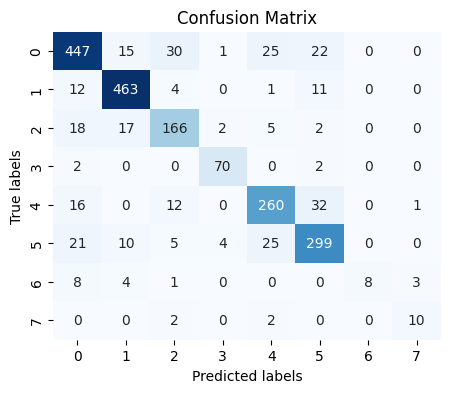

In [ ]:
# cm, _, accuracy, micro_f1 = evaleate_model(model, tokenized_val_dataset, device)
cm, validation_report, accuracy = evaleate_model(model, trainer, tokenized_val_dataset, device)
print("Metrics for current model:")
print(f'Test accuracy: {accuracy:.4f}')
print(validation_report)
# print(f'Test F1 micro: {micro_f1:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))